## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.append('../')

import os

import torch
import matplotlib.pyplot as plt
import numpy as np

from util.icon_dataset import Data, Transformation
import models_mae
import models_conv_mae

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [2]:
DUTS_MEAN = np.array([102.94, 118.90, 124.55])
DUTS_STD = np.array([57.50, 55.97, 56.77])


def run_one_image(img, mask_gt, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model.forward_rec(x.float(), mask_ratio=0.75)
    seg_pred = model.forward_seg(x.float(), inference=True)
    y = y.detach().cpu()
    y = torch.einsum('nchw->nhwc', y)

#     seg_pred = seg_pred.view(mask_gt.shape).detach().cpu().unsqueeze(0)
#     seg_pred = model.unpatchify(seg_pred)
    print(seg_pred.shape)

    seg_pred = seg_pred.detach().cpu()
    seg_pred = torch.einsum('nchw->nhwc', seg_pred)

    # visualize the mask
    mask = mask.detach()
    mask = torch.einsum('nchw->nhwc', mask)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 15]

    plt.subplot(2, 3, 1)
    show_image(x[0], "original")

    plt.subplot(2, 3, 2)
    show_image(mask_gt, "GT segmentation")

    plt.subplot(2, 3, 3)
    show_image(seg_pred[0], "Pred. segmentation")

    plt.subplot(2, 3, 4)
    show_image(im_masked[0], "masked")

    plt.subplot(2, 3, 5)
    show_image(y[0], "reconstruction")

    plt.subplot(2, 3, 6)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

def show_image(image, title=''):
    # image is [H, W, 3]
    if len(image.shape) > 2 and image.shape[2] == 3:
        plt.imshow(torch.clip((image * DUTS_STD + DUTS_MEAN), 0, 255).int())
    else:
        plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

### Load model and data


In [3]:
size = 384

# model = getattr(models_mae, 'mae_vit_base_patch16_seg')()
model = getattr(models_conv_mae, 'mae_vit_base_patch16_seg_conv_unet')(img_size=size)

# load model
# checkpoint = torch.load('../ckpts/unet_small_seg+rec_best_384.pth', map_location='cpu')
# checkpoint = torch.load('../ckpts/conv_seg+rec0-best.pth', map_location='cpu')
checkpoint = torch.load('../ckpts/unet3_bce_iou-best.pth', map_location='cpu')

msg = model.load_state_dict(checkpoint['model'], strict=True)

path = os.path.join('icon-datasets', 'DUTS', 'Test')

transform_val = Transformation(train=False, size=size)

dataset = Data(root=os.path.join('/Users/panda/Technion/datasets', path), size=size, transform=transform_val)


### Demo

torch.Size([1, 1, 384, 384])


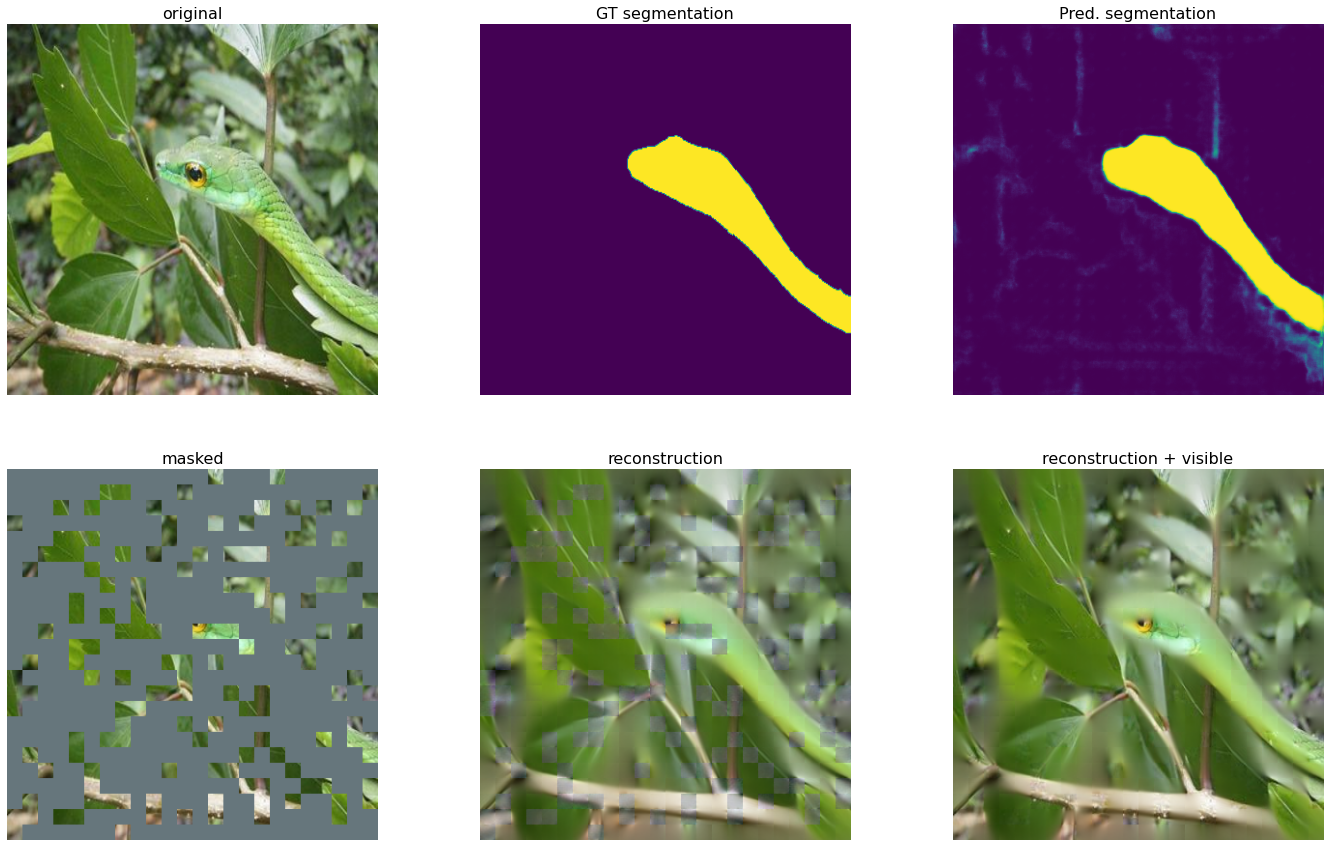

torch.Size([1, 1, 384, 384])


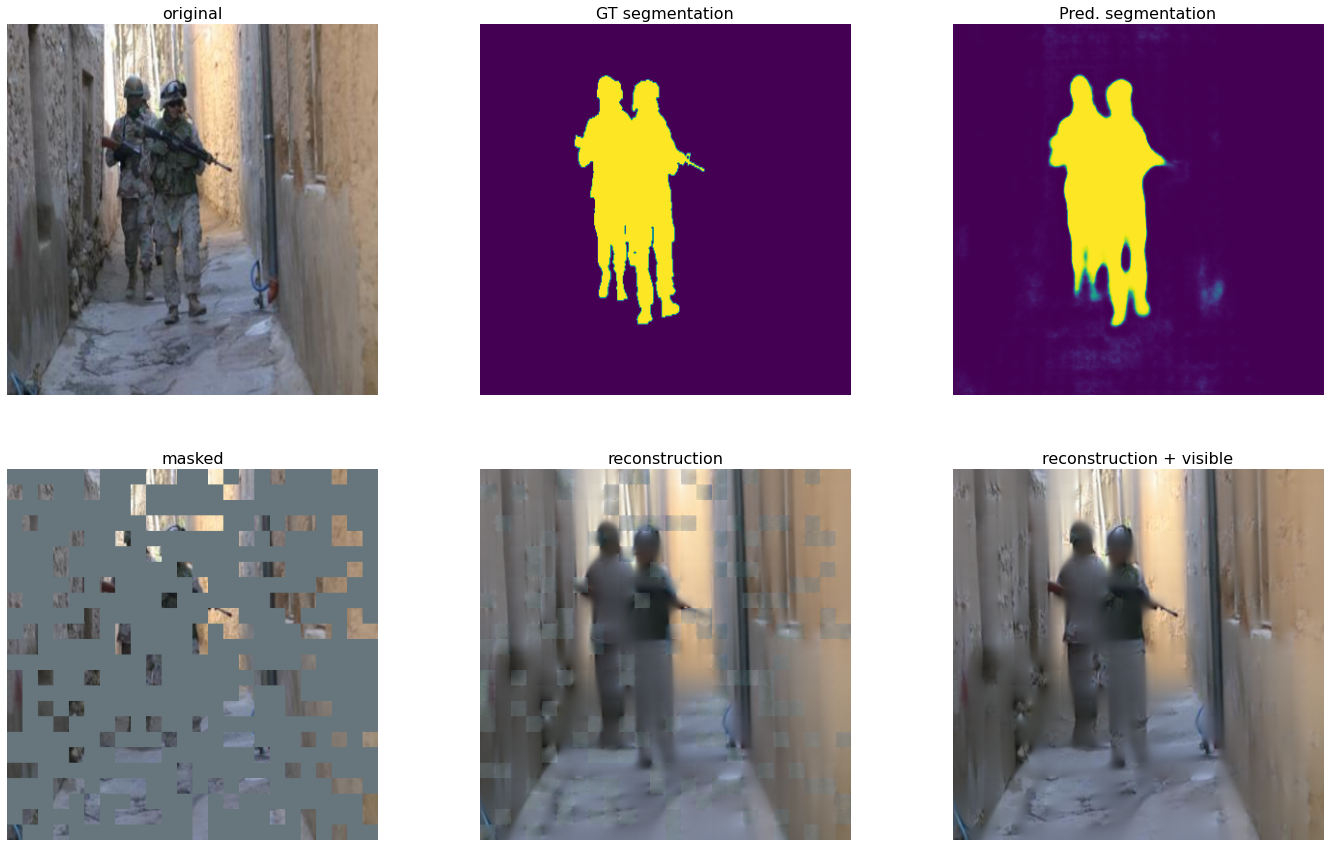

torch.Size([1, 1, 384, 384])


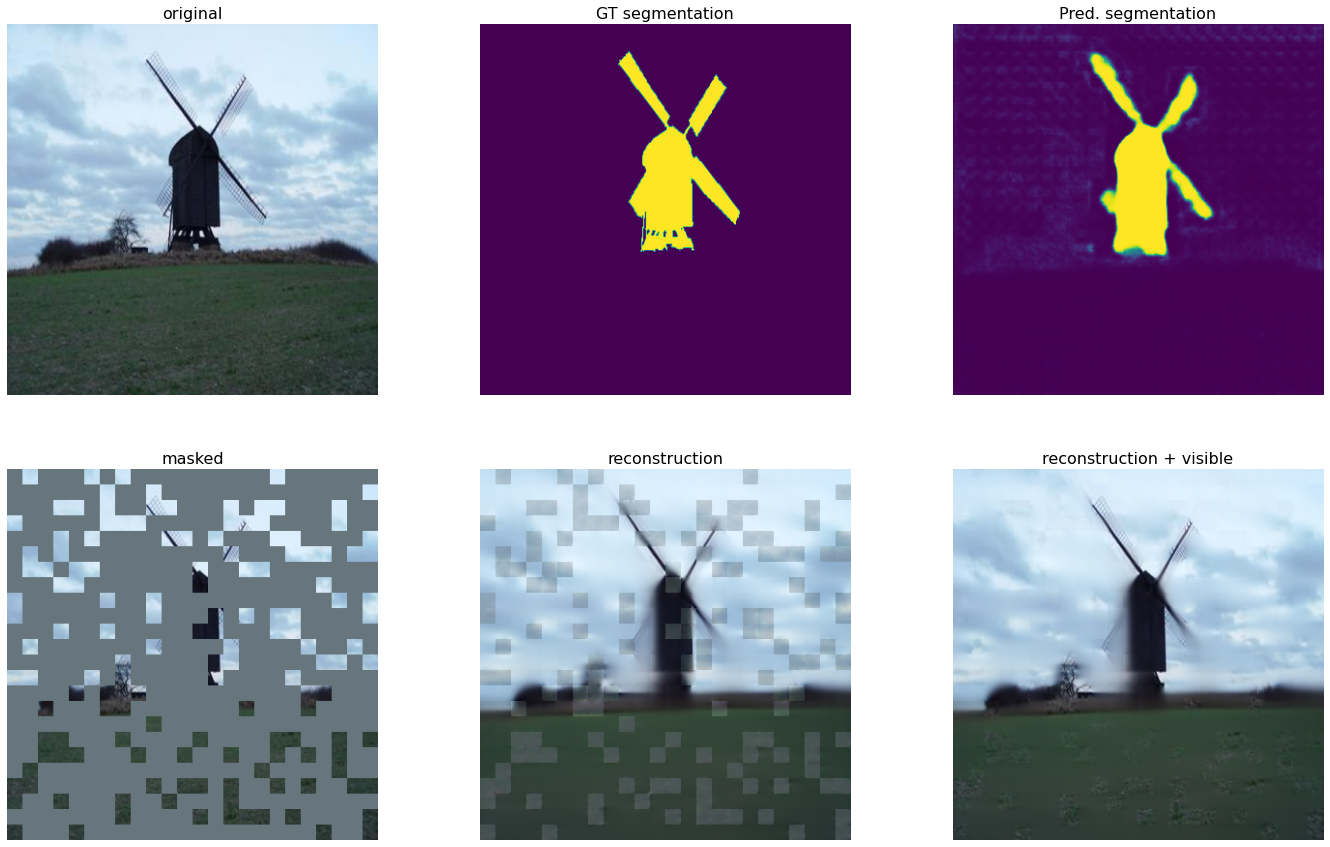

torch.Size([1, 1, 384, 384])


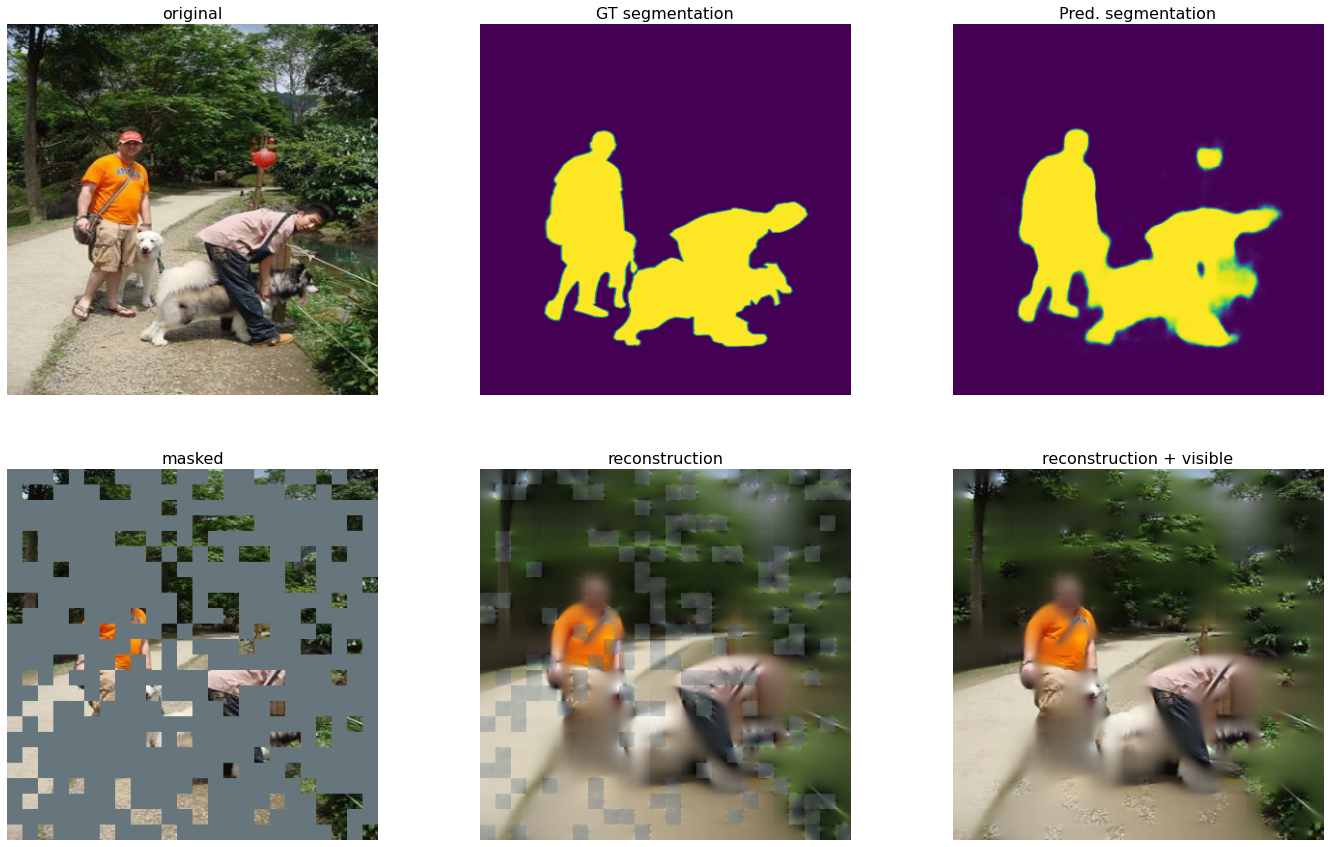

torch.Size([1, 1, 384, 384])


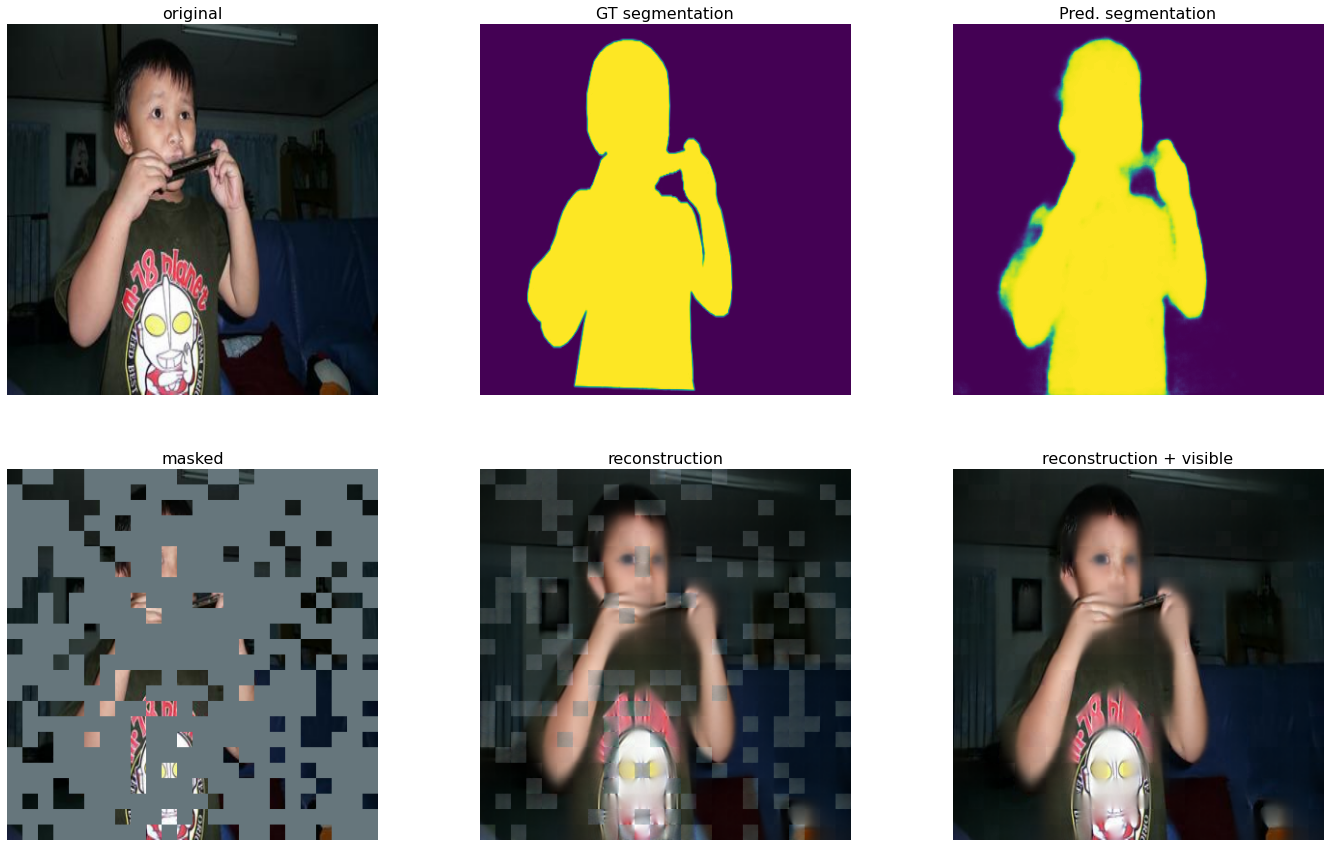

torch.Size([1, 1, 384, 384])


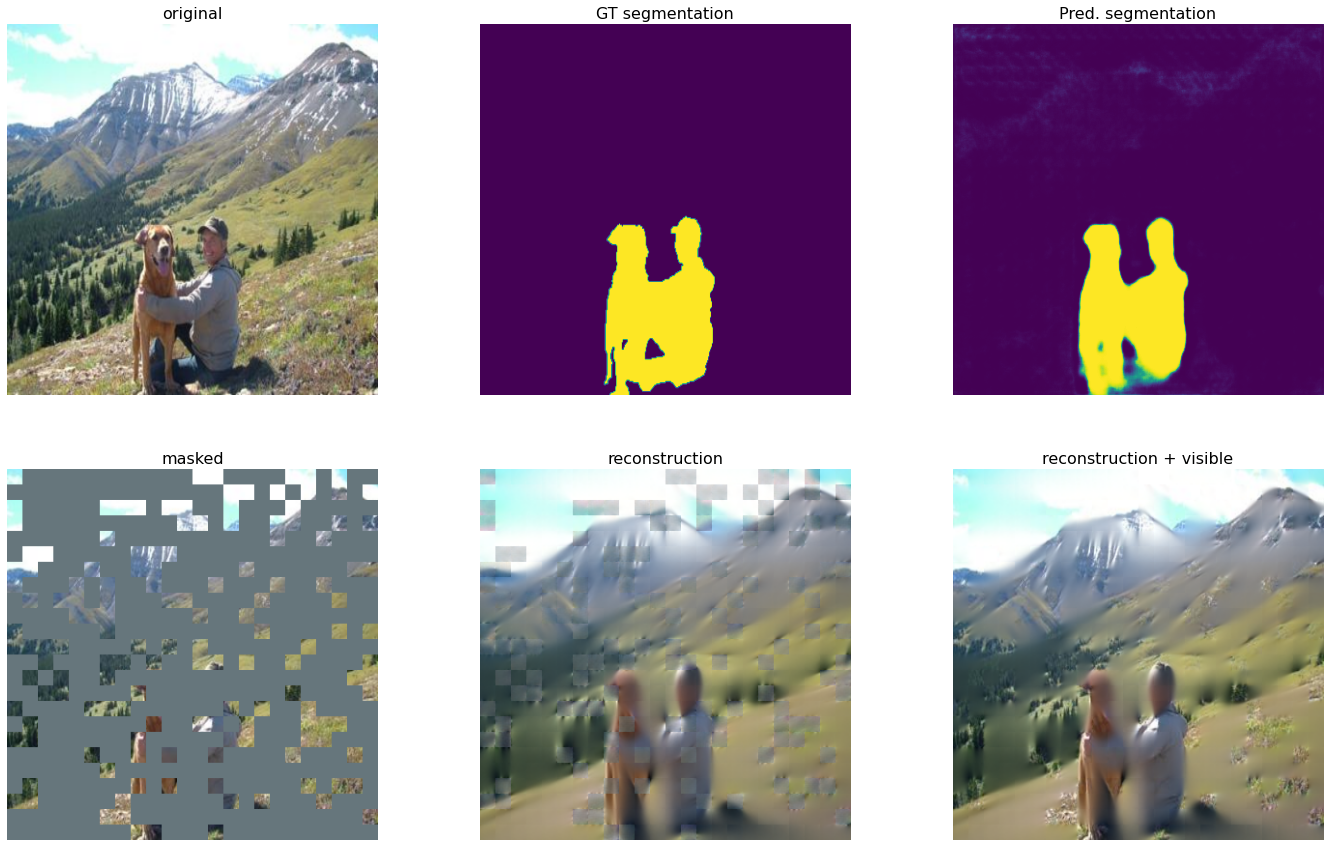

torch.Size([1, 1, 384, 384])


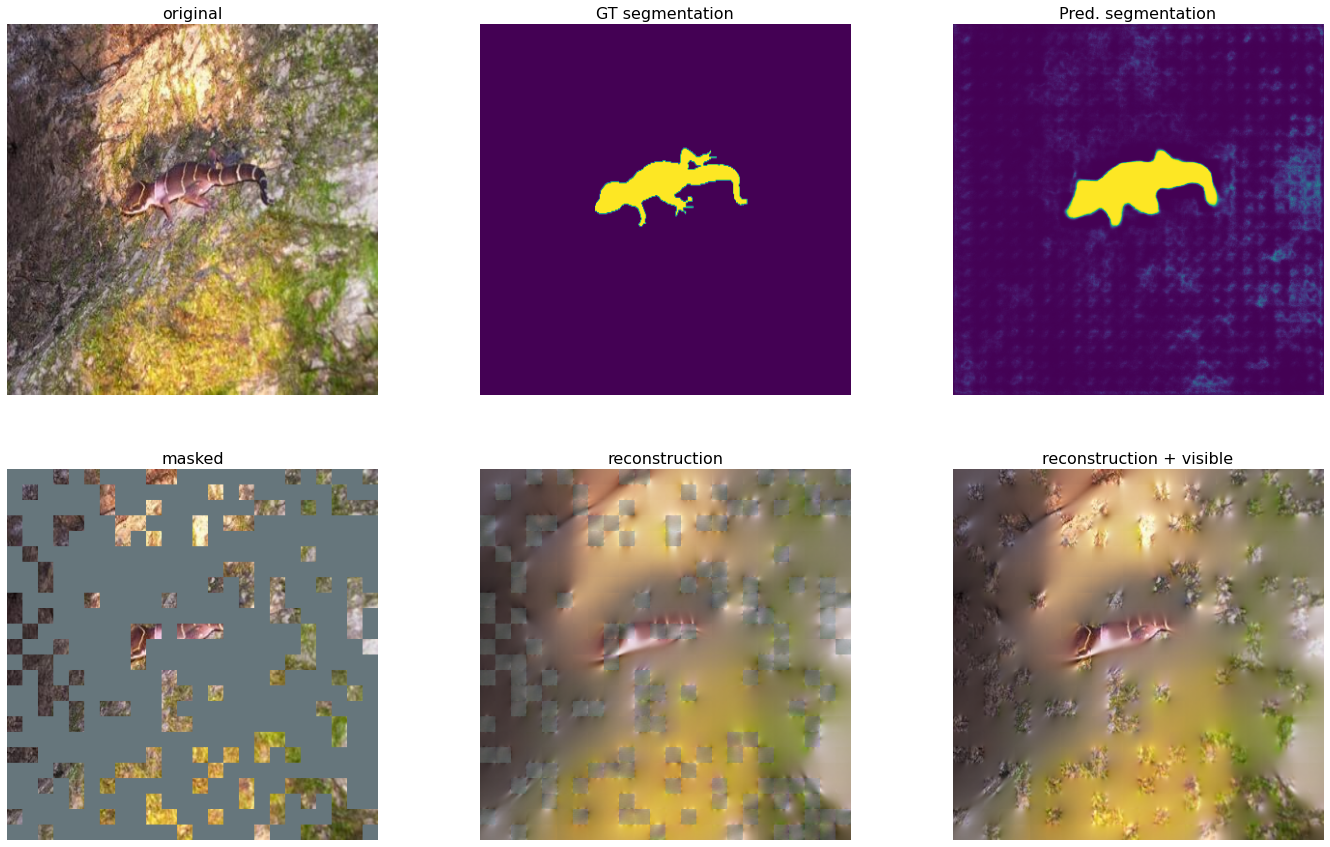

torch.Size([1, 1, 384, 384])


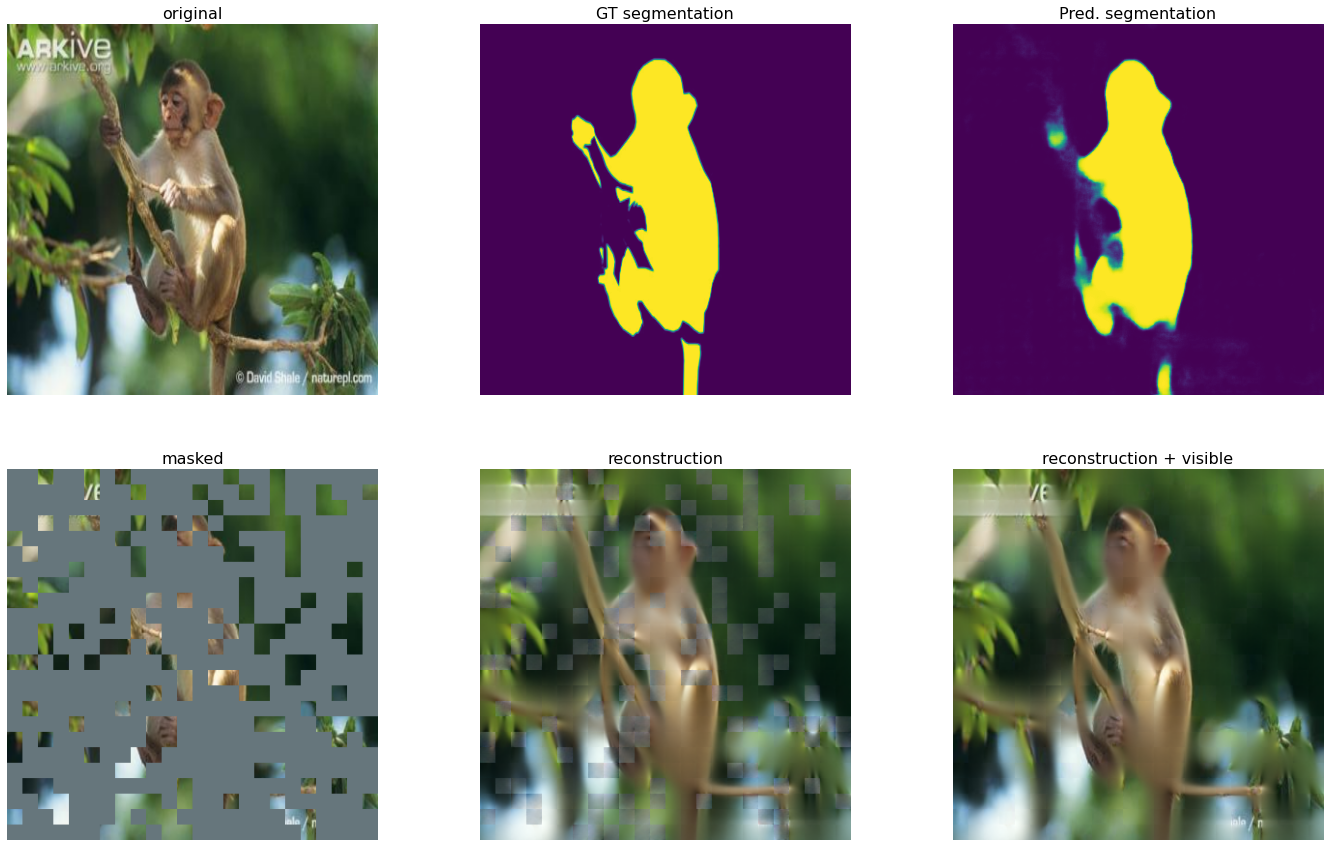

torch.Size([1, 1, 384, 384])


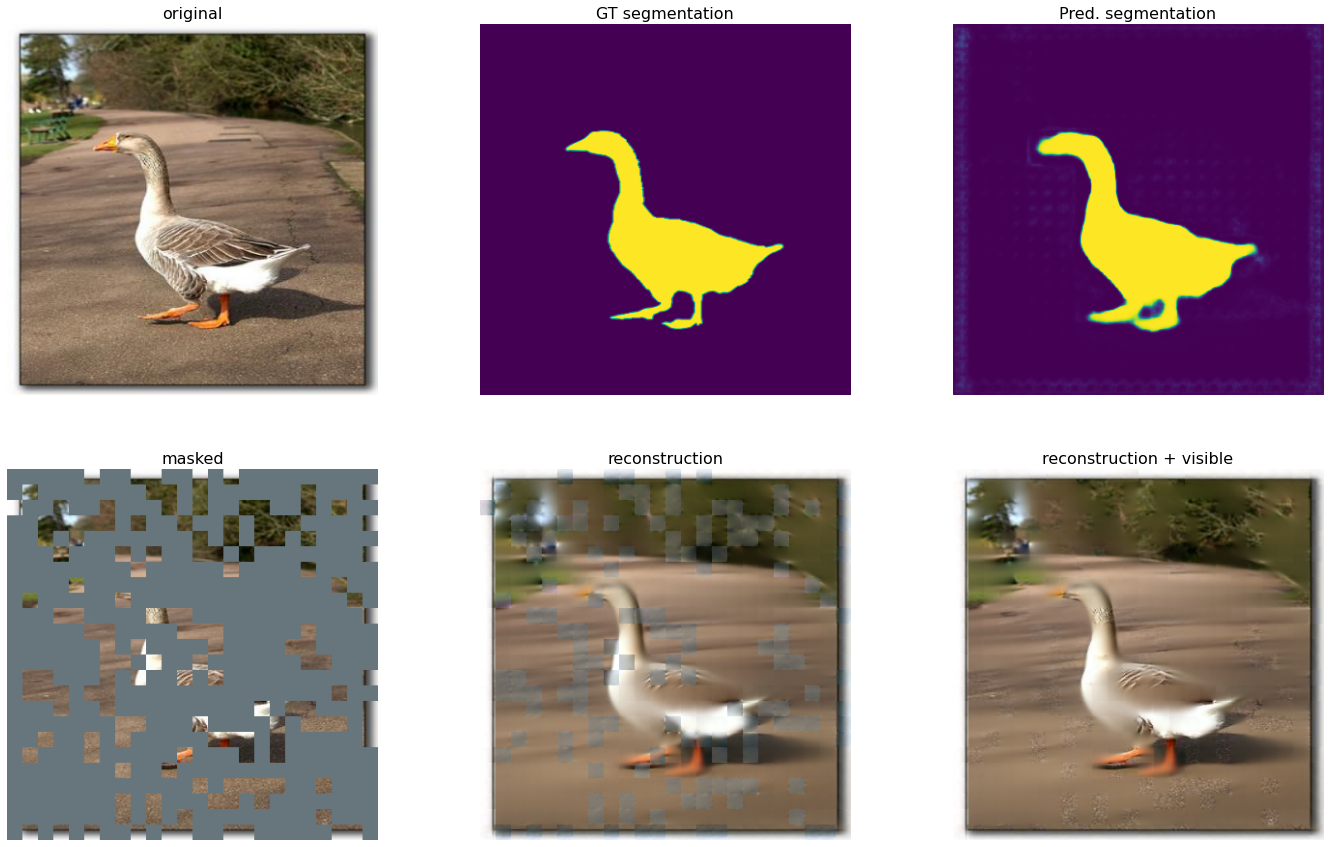

torch.Size([1, 1, 384, 384])


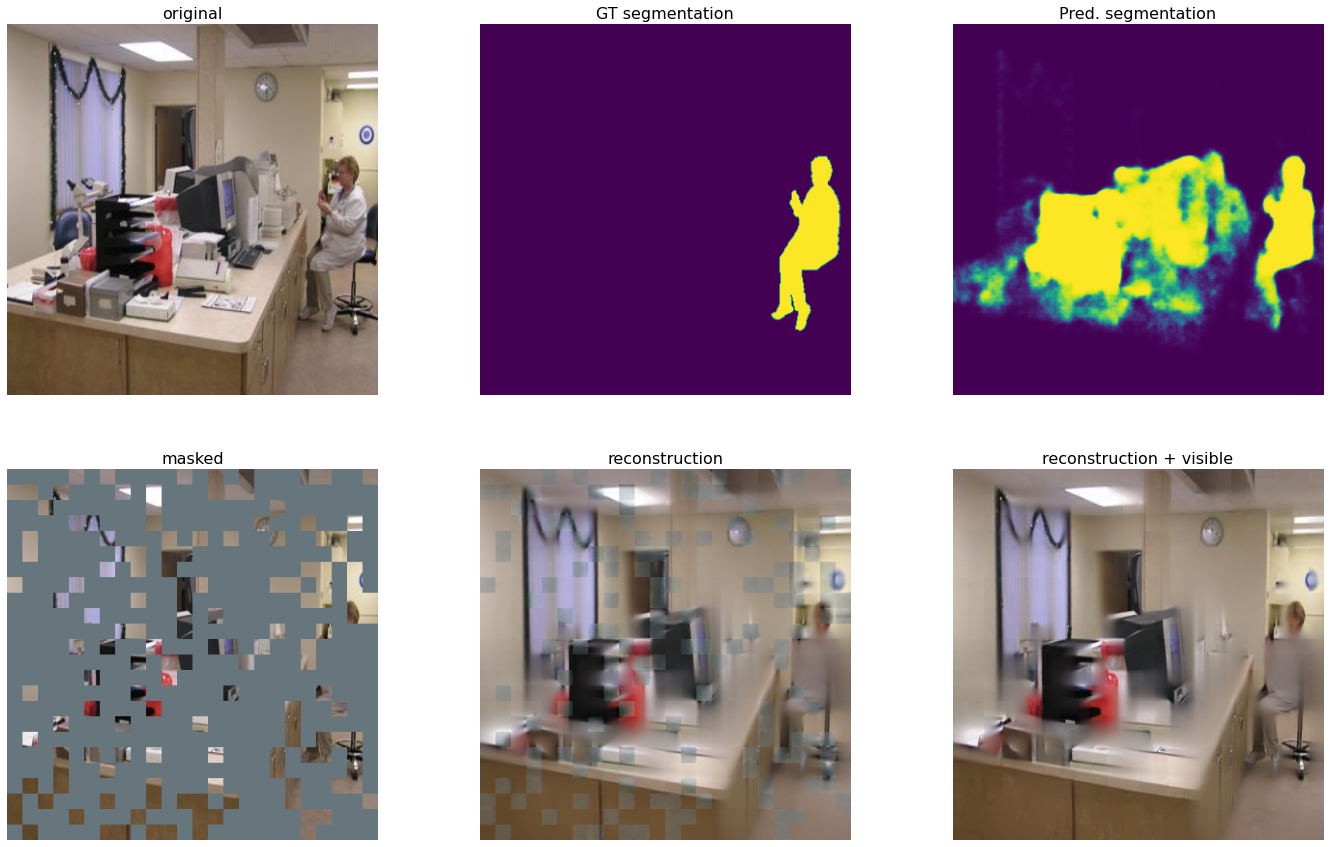

In [5]:
for idx in range(10, 20):

    im, mask, _ = dataset[idx]

    run_one_image(im, mask, model)
